## Load Libraries

In [ ]:
import datetime
import pandas as pd
import seaborn as sns
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from metloom.pointdata import SnotelPointData

: 

## Load Data

In [2]:
snotel_with_class=pd.read_parquet('../data/snotel_with_class.parquet')
snotel_with_class.info()
snotel_with_class.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907 entries, 0 to 906
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   site_name  907 non-null    object 
 1   latitude   907 non-null    float64
 2   longitude  907 non-null    float64
 3   elevation  907 non-null    int64  
 4   triplets   907 non-null    object 
 5   snowclass  907 non-null    object 
dtypes: float64(2), int64(1), object(3)
memory usage: 42.6+ KB


,site_name,latitude,longitude,elevation,triplets,snowclass
0,Alexander Lake (1267),61.75,-150.89,160,1267:AK:SNTL,Alpine
1,American Creek (1189),64.79,-141.23,1050,1189:AK:SNTL,Taiga
2,Anchor River Divide (1062),59.86,-151.32,1653,1062:AK:SNTL,Alpine
3,Anchorage Hillside (1070),61.11,-149.67,2080,1070:AK:SNTL,Tundra
4,Aniak (2065),61.58,-159.58,80,2065:AK:SNTL,Taiga


In [3]:
gdf_snotel = gpd.GeoDataFrame(
    snotel_with_class, 
    geometry=gpd.points_from_xy(snotel_with_class['longitude'], snotel_with_class['latitude']),
    crs="EPSG:4326"  # CRS for WGS84 (latitude/longitude)
)

gdf_snotel.head()

,site_name,latitude,longitude,elevation,triplets,snowclass,geometry
0,Alexander Lake (1267),61.75,-150.89,160,1267:AK:SNTL,Alpine,POINT (-150.89000 61.75000)
1,American Creek (1189),64.79,-141.23,1050,1189:AK:SNTL,Taiga,POINT (-141.23000 64.79000)
2,Anchor River Divide (1062),59.86,-151.32,1653,1062:AK:SNTL,Alpine,POINT (-151.32000 59.86000)
3,Anchorage Hillside (1070),61.11,-149.67,2080,1070:AK:SNTL,Tundra,POINT (-149.67000 61.11000)
4,Aniak (2065),61.58,-159.58,80,2065:AK:SNTL,Taiga,POINT (-159.58000 61.58000)


In [4]:
# shape file was downloaded from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/

world = gpd.read_file('../data/shape_files/ne_110m_admin_0_countries.shp')
usa=world.query('SOVEREIGNT == "United States of America"')

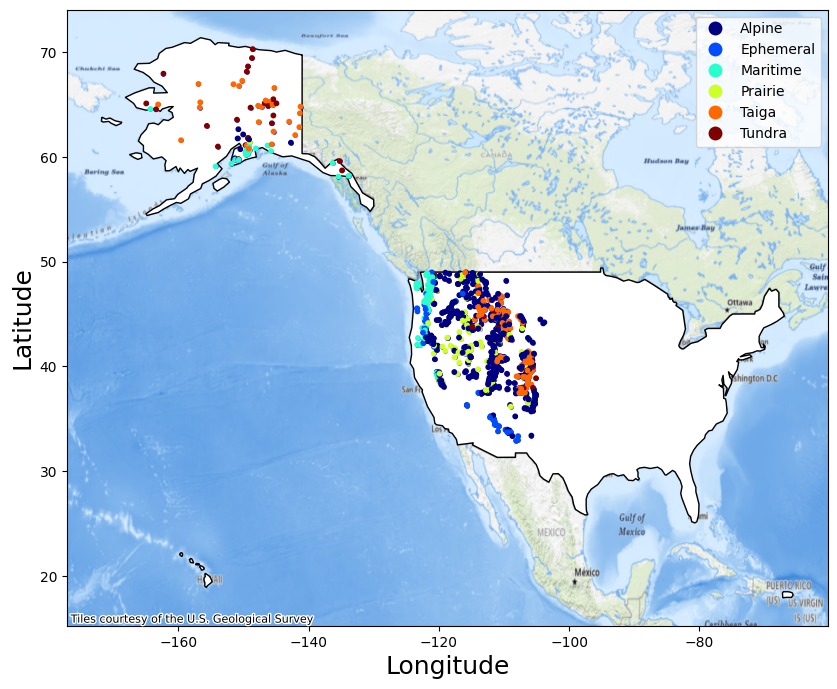

In [7]:
# Plot the SNOTEL sites on the map
fig, ax = plt.subplots(figsize=(10, 8))

# Plot USA boundaries
usa.plot(ax=ax, color='white', edgecolor='black')

gdf_snotel.plot(ax=ax, color='blue', markersize=5, label='SNOTEL Sites')
gdf_snotel.plot(
    ax=ax, 
    column='snowclass',  # Column used for color differentiation
    legend=True,  # Show legend for snow classes
    markersize=10,  # Adjust marker size
    cmap='jet',  # Choose a color map for snow classes jet, turbo,
    label='SNOTEL Sites'
)
ctx.add_basemap(ax, crs=gdf_snotel.crs.to_string(), source=ctx.providers.USGS.USTopo, zoom=4)


plt.xlabel('Longitude', fontsize=18)
plt.ylabel('Latitude', fontsize=18)
plt.savefig('../plots/study_arae.jpg', dpi=300)
plt.show()

In [5]:
# Let's select Banner Summit in Idaho
pt = SnotelPointData("312:ID:SNTL", "Banner Summit")

# start data and end date
start_date = datetime.datetime(2004, 12, 1)
end_date = datetime.datetime(2006, 5, 15)

variables = [
    pt.ALLOWED_VARIABLES.SWE,
    pt.ALLOWED_VARIABLES.SNOWDEPTH,
]

df = pt.get_daily_data(start_date, end_date, variables)
df.head(3)


,,geometry,SWE,SWE_units,SNOWDEPTH,SNOWDEPTH_units,datasource
datetime,site,,,,,,
2004-12-01 08:00:00+00:00,312:ID:SNTL,POINT Z (-115.23447 44.30342 7040.00000),2.9,in,14.0,in,NRCS
2004-12-02 08:00:00+00:00,312:ID:SNTL,POINT Z (-115.23447 44.30342 7040.00000),3.0,in,13.0,in,NRCS
2004-12-03 08:00:00+00:00,312:ID:SNTL,POINT Z (-115.23447 44.30342 7040.00000),3.0,in,13.0,in,NRCS


In [6]:
clean_df=(
    df
    .drop(columns='geometry')
    .reset_index()
    .rename(columns={'datetime': 'Date'})
    .query("~Date.between(left='2005-05-16', right='2005-11-30', inclusive='both')")
    .assign(
        Winter=lambda x: x.Date.map(lambda y: "2004-2005" if y >= pd.Timestamp("2004-12-01", tz='UTC') and y <= pd.Timestamp("2005-05-30", tz='UTC') else "2005-2006"),
        # Date= lambda x: x.Date.dt.date,
        SWE = lambda x: x.SWE*2.54,
        Snow_Depth = lambda x: x.SNOWDEPTH*2.54,
        Snow_Density = lambda x: (x.SWE/x.Snow_Depth) * 1000
    )
    .rename(columns={
        'Snow_Depth': 'Snow Depth',
        'Snow_Density': 'Snow Density'
    })
    .filter(items=['Date', 'Winter', 'Snow Depth', 'Snow Density'])
    .reset_index(drop=True)
    .melt(id_vars=['Date', 'Winter'], value_vars=['Snow Depth', 'Snow Density'], var_name='Measurement', value_name='Value')
    .assign(
        Measurement=lambda x: x.Measurement.map(lambda y: 'Snow Depth (cm)' if y == 'Snow Depth' else 'Snow Density (kg/m^3)'),
        Date_=lambda x: x.Date.map(lambda y: pd.Timestamp(y.year+1, y.month, y.day, tz='UTC') if y >= pd.Timestamp("2004-12-01", tz='UTC') and y <= pd.Timestamp("2005-05-30", tz='UTC') else y)
    )
)

clean_df.head()

,Date,Winter,Measurement,Value,Date_
0,2004-12-01 08:00:00+00:00,2004-2005,Snow Depth (cm),35.56,2005-12-01 00:00:00+00:00
1,2004-12-02 08:00:00+00:00,2004-2005,Snow Depth (cm),33.02,2005-12-02 00:00:00+00:00
2,2004-12-03 08:00:00+00:00,2004-2005,Snow Depth (cm),33.02,2005-12-03 00:00:00+00:00
3,2004-12-04 08:00:00+00:00,2004-2005,Snow Depth (cm),33.02,2005-12-04 00:00:00+00:00
4,2004-12-05 08:00:00+00:00,2004-2005,Snow Depth (cm),33.02,2005-12-05 00:00:00+00:00


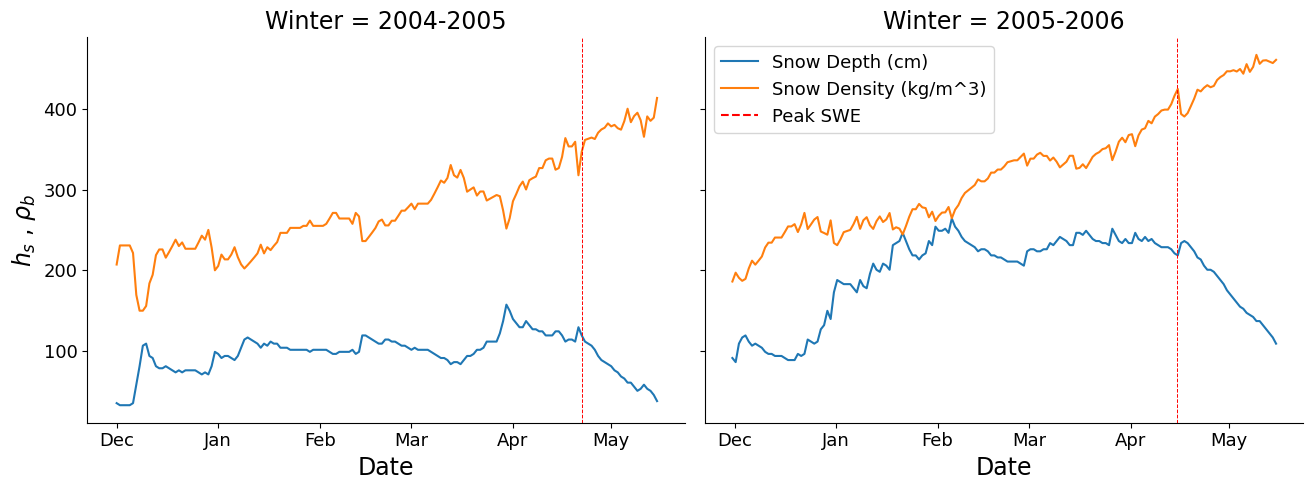

In [18]:
g = sns.FacetGrid(clean_df, col='Winter', hue='Measurement', height=5, aspect=1)
g.map_dataframe(sns.lineplot, 'Date_', 'Value')

# Define positions for the vertical lines for each category
vertical_lines = {
    '2004-2005': datetime.datetime(2006, 4, 22),
    '2005-2006': datetime.datetime(2006, 4, 15)
}
g.set_axis_labels("Date", r"$h_s$ , $\rho_b$", fontsize=17)
g.add_legend(fontsize=15)

for ax in g.axes.flat:
    ax.tick_params(axis='y', labelsize=13)

# Draw vertical lines at the specified positions
for ax, category in zip(g.axes.flatten(), vertical_lines.keys()):
    ax.axvline(x=vertical_lines[category], color='red', linestyle='--', label='Peak SWE', linewidth=0.7)

for ax in g.axes.flat:
    ax.xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to every month
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Format to abbreviated month names
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)  # Rotate labels for better readability
g.set_xticklabels(rotation=0, fontsize=13)

g._legend.set_title(None)
g.set_titles(size=17)

handles, labels = g.legend.legend_handles, [text.get_text() for text in g.legend.texts]
handles.append(plt.Line2D([0], [0], color='red', linestyle='--'))  # Add the vertical line handle
labels.append("Peak SWE")  # Add the label for the vertical line

# Update the legend with the new handles and labels
g._legend.remove()  # Remove the old legend
plt.legend(handles=handles, labels=labels, fontsize=13, loc='best')
plt.tight_layout()

plt.savefig('../plots/banner_summit.jpg', dpi=300)
plt.show()